# MAP ESTIMES FOR SOURCES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('../')

In [2]:

import hmac
import matplotlib.pyplot as plt
from src.HMC_Single_Star_cosdist import HMC_Sampler
from src import NF_Cos_dist
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.colors as mcolors

nf=NF_Cos_dist.JaxNormFlow()

hmc=HMC_Sampler()

/opt/homebrew/Caskroom/miniforge/base/envs/flowjax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/flowjax/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


8164992
7558434
8164992
7558434


### Sample stars to be the zero extinction candadites.

In [3]:
rng_key = jax.random.PRNGKey(0)
samples=nf.flow.sample(rng_key, sample_shape=(50000,))+nf.mean

log_prob_prior_x=nf.flow.log_prob(samples-nf.mean)


In [4]:
 q=hmc.run_model_single(0)

sample: 100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s, 1023 steps of size 8.71e-07. acc. prob=0.76]


In [5]:
q

(Array(0.7953929, dtype=float32), Array(2.3841858e-07, dtype=float32))

In [6]:
hmc.data[0,:]

Array([7.9709377 , 2.0335245 , 1.6318312 , 2.0282993 , 1.0639353 ,
       0.40199947, 0.10099983, 2.0994997 , 1.6325998 , 1.4345999 ,
       1.3603001 , 1.3031998 ], dtype=float32)

In [7]:
#log_prob_prior_x_grad=[jax.vmap(jax.jacfwd(jax.grad(nf.flow.log_prob)))((samples-nf.mean)[i*10000:10000*(i+1)]) for i in range(10)]

In [8]:
#log_prob_prior_x_grad=jnp.concatenate(log_prob_prior_x_grad,0)

In [9]:
mus,stds,a0s,lps,samps=[],[],[],[],[]
for i in np.arange(-0.1,1.5,0.02):
    if(i<0.0):
        mu,std=hmc.extincted_phot(samples,a0=jnp.abs(i)*jnp.ones_like(samples[:,0]),subtract=True)
    else:
        mu,std=hmc.extincted_phot(samples,a0=i*jnp.ones_like(samples[:,0]),subtract=False)
    samps.append(samples)
    mus.append(mu)
    stds.append(std)
    a0s.append(i*jnp.ones_like(samples[:,0]))
    lps.append(log_prob_prior_x)
    #grads.append(log_prob_prior_x_grad)
mus=np.concatenate(mus,0)
stds=np.concatenate(stds,0)
a0s=np.concatenate(a0s,0)
lps=np.concatenate(lps,0)
samps=np.concatenate(samps,0)
#grads=np.concatenate(grads,0)

In [10]:
mu.shape

(50000, 12)

#### Observation part

In [11]:
j=0
test_point=hmc.data[j]
test_point_error=hmc.error[j]

ins=jnp.concatenate((a0s[:,None],samps),1)


In [12]:
def full_likelihood(x,y,V):
    a0,x=x[:,0],x[:,1:]
    mu_x,std_x=hmc.extincted_phot(x,a0=a0)

    T=jnp.einsum('ij,jj->ij',(mu_x-y),jnp.linalg.inv(V))#[:,np.array([1,2,3,4,5,6,7,8,9,10,11])]
    T=jnp.einsum('ij,ij->i',T,(mu_x-y))#[:,np.array([1,2,3,4,5,6,7,8,9,10,11])])
    return -0.5*T

In [13]:
out_log_likelihood=full_likelihood(ins,test_point[:],test_point_error[:])

log_prob=out_log_likelihood+lps

In [14]:
log_prob

Array([-23315136., -12350955., -21548786., ..., -15261508., -15104298.,
       -22833194.], dtype=float32)

(0.0, 30.0)

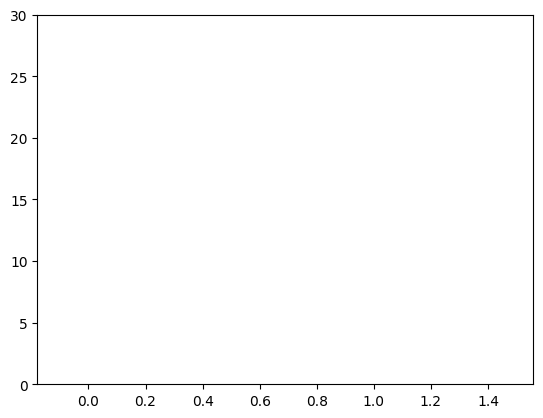

In [15]:
plt.scatter(a0s,log_prob)
plt.ylim(0,30)

In [16]:
argmax=jnp.argmax(log_prob)

In [17]:
a0s[argmax]

0.06

In [18]:
def full_probability(x,y,V):
    a0,x=x[0],x[1:]
    mu_x,std_x=hmc.extincted_phot(x[None,:],a0=a0[None])

    T=jnp.einsum('ij,jj->ij',(mu_x-y),jnp.linalg.inv(V))
    T=jnp.einsum('ij,ij->i',T,(mu_x-y))
    
    return -0.5*T.mean()+nf.flow.log_prob(x-nf.mean).mean()

In [19]:
grad=-1*(jax.jacfwd(jax.jacfwd(full_probability,argnums=0)))(ins[argmax],test_point[:],test_point_error[:])


In [20]:
cov=jnp.linalg.inv(grad)

In [21]:
cov

Array([[-9.27139918e-05, -3.67632869e-11,  1.13295464e-05,
         8.17896580e-05,  9.84557410e-05,  3.67443135e-05,
         9.87163094e-06, -7.03053138e-06,  1.05617335e-04,
         7.21450269e-05,  4.84337106e-05,  3.73512812e-05,
         2.94005768e-05],
       [-3.67618574e-11,  1.79744418e-07,  4.18352419e-12,
         6.29734112e-11, -1.12244158e-10, -4.46389106e-11,
         4.12726797e-10, -1.13611315e-10,  6.32515498e-11,
         3.15228364e-11, -3.12093025e-11,  1.15470871e-11,
         1.42020756e-10],
       [ 1.13295482e-05,  4.18363608e-12, -1.20467575e-06,
        -9.99454551e-06, -1.20313398e-05, -4.49005165e-06,
        -1.20591233e-06,  8.60019156e-07, -1.29063164e-05,
        -8.81604137e-06, -5.91831440e-06, -4.56429007e-06,
        -3.59262799e-06],
       [ 8.17896725e-05,  6.29742855e-11, -9.99454642e-06,
        -6.61776576e-05, -8.55290928e-05, -3.12172015e-05,
        -9.25430140e-06,  5.29605632e-06, -9.30150563e-05,
        -6.36236073e-05, -4.16247640e

In [22]:
std_dev = np.sqrt((np.diag(cov)))

# Compute the correlation matrix
correlation_matrix = cov / np.outer(std_dev, std_dev)

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_86220/1683043258.py:1: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt((np.diag(cov)))


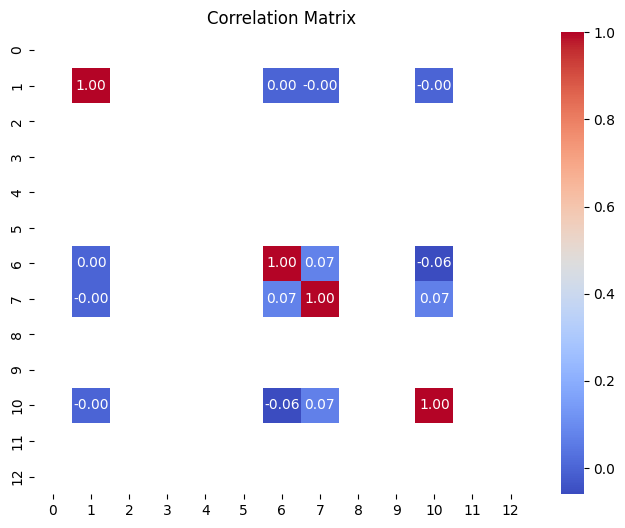

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Set the title and show the plot
plt.title('Correlation Matrix')
plt.show()


In [24]:
jnp.sqrt(jnp.abs(jnp.diag(cov)))

Array([0.00962881, 0.00042396, 0.00109758, 0.00813496, 0.00983954,
       0.00277433, 0.01667917, 0.01575222, 0.01085037, 0.00745376,
       0.00454589, 0.00383619, 0.00163206], dtype=float32)

# Full run

In [25]:
len(hmc.data)

38

In [26]:
d=nf.data+nf.mean
d=d#[:len(d)//32]#[::150]

In [27]:
exts=[]
exts_std=[]

In [28]:

for j in range(0,len(hmc.data)): 
    test_point=hmc.data[j]
    test_point_error=hmc.error[j]

    ins=jnp.concatenate((a0s[:,None],samps),1)



    out_log_likelihood=full_likelihood(ins,test_point[:],test_point_error[:])

    log_prob=out_log_likelihood+lps

    argmax=jnp.argmax(log_prob)


    grad=-1*(jax.jacfwd(jax.jacfwd(full_probability,argnums=0)))(ins[argmax],test_point[:],test_point_error[:])


    cov=jnp.linalg.inv(grad)

    exts.append(a0s[argmax])
    exts_std.append(cov[0,0])



In [29]:
len(exts)

38

In [30]:
valid=np.argwhere(np.array(hmc.data[:,1]>2))
#valid=np.argwhere(np.array(exts)<0.7)

In [31]:
len(valid)

30

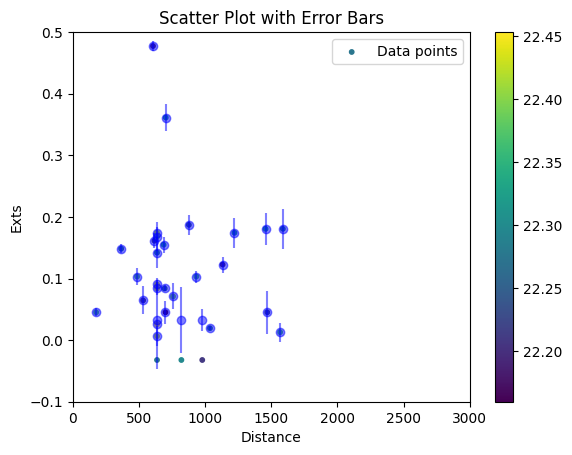

In [32]:
dist=hmc.distance[valid]
plt.scatter(dist[valid], np.array(exts)[valid]/3.1, c=hmc.b[valid], label='Data points',s=10)
plt.colorbar()
# Add error bars
plt.errorbar(dist[valid][:,0], np.abs(np.array(exts))[valid][:,0]/3.1, yerr=np.sqrt(np.abs(exts_std)[valid])[:,0]/3.1, fmt='o', color='blue', alpha=0.5)

# Set x-axis limit
plt.xlim(0, 3000)
plt.ylim(-0.1,0.5)
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Exts')
plt.title('Scatter Plot with Error Bars')

# Optionally, add a legend
plt.legend()

# Show plot
plt.show()

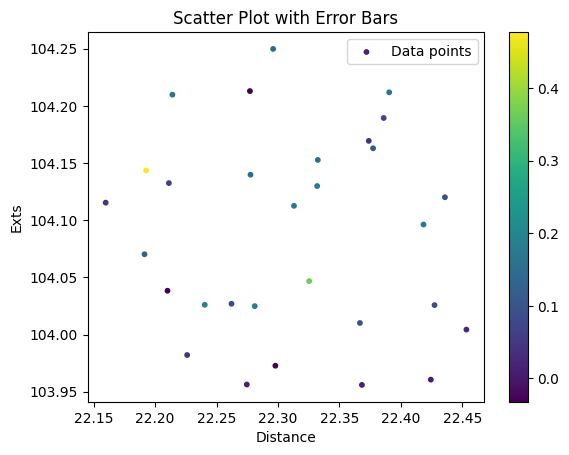

In [33]:
dist=hmc.distance[valid]
plt.scatter(y=hmc.l[valid], c=np.array(exts)[valid]/3.1, x=hmc.b[valid], label='Data points',s=10)
plt.colorbar()
# Add error bars
#plt.errorbar(dist[valid][:,0], np.abs(np.array(exts))[valid][:,0]/3.1, yerr=np.sqrt(np.abs(exts_std)[valid])[:,0]/3.1, fmt='o', color='blue', alpha=0.5)

# Set x-axis limit
#plt.xlim(0, 2000)
#plt.ylim(-0.1,0.5)
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Exts')
plt.title('Scatter Plot with Error Bars')

# Optionally, add a legend
plt.legend()

# Show plot
plt.show()

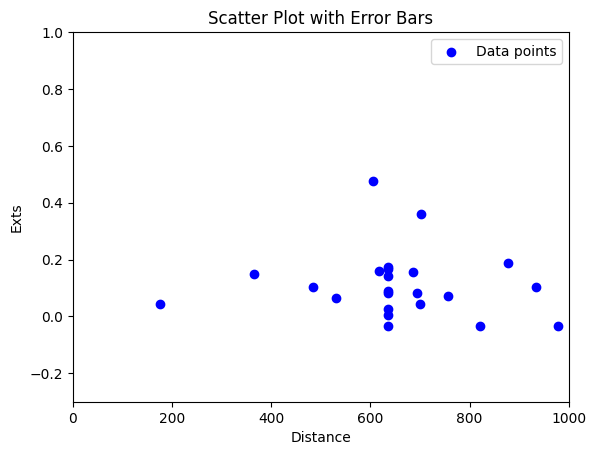

In [34]:
dist=hmc.distance[valid]
plt.scatter(dist[valid], np.array(exts)[valid]/3.1, color='blue', label='Data points')

# Add error bars
#plt.errorbar(dist[valid][:,0], np.abs(np.array(exts))[valid][:,0]/3.1, yerr=np.sqrt(np.abs(exts_std)[valid])[:,0]/3.1, fmt='o', color='blue', alpha=0.5)

# Set x-axis limit
plt.xlim(0, 1000)
plt.ylim(-0.3,1.0)
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Exts')
plt.title('Scatter Plot with Error Bars')

# Optionally, add a legend
plt.legend()

# Show plot
plt.show()

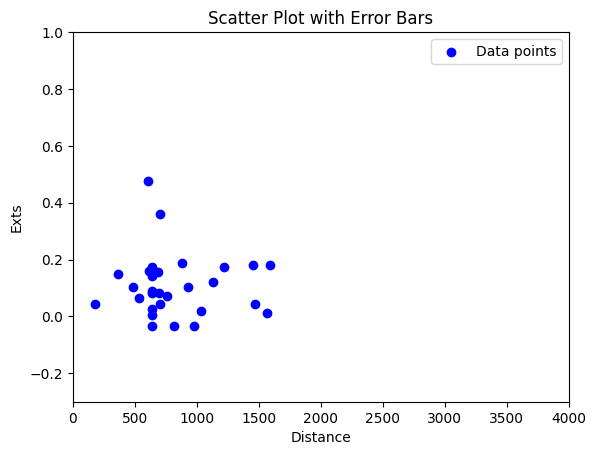

In [35]:
dist=hmc.distance[valid]
plt.scatter(dist[valid], np.array(exts)[valid]/3.1, color='blue', label='Data points')

# Add error bars
#plt.errorbar(dist[valid][:,0], np.abs(np.array(exts))[valid][:,0]/3.1, yerr=np.sqrt(np.abs(exts_std)[valid])[:,0]/3.1, fmt='o', color='blue', alpha=0.5)

# Set x-axis limit
plt.xlim(0, 4000)
plt.ylim(-0.3,1.0)
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Exts')
plt.title('Scatter Plot with Error Bars')

# Optionally, add a legend
plt.legend()

# Show plot
plt.show()

(10.0, -2.0)

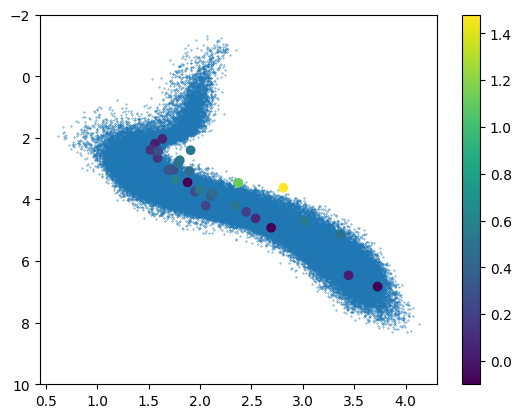

In [36]:
d=(nf.data+nf.mean)[:len(nf.data)//32]

plt.scatter(d[:,2],d[:,1],s=0.1)

plt.scatter(hmc.data[valid,2],hmc.data[valid,1],c=np.array(exts)[valid])
plt.colorbar()
plt.ylim(10,-2)


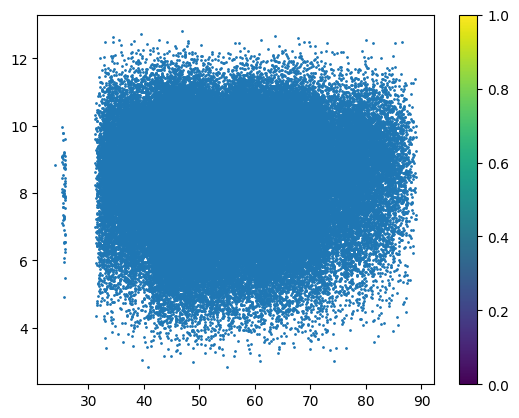

In [37]:
d=(nf.data+nf.mean)[:len(nf.data)//32]

plt.scatter(y=d[:,0],s=1,x=np.abs(nf.b)[:len(nf.data)//32])
#plt.scatter(samples[:,0],samples[:,1],s=1)

#plt.scatter(hmc.data[valid,0],hmc.data[valid,1])
plt.colorbar()
#plt.ylim(8,0)


/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_86220/795392558.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(hmc.data[valid,0],hmc.data[valid,1],c=np.sqrt(np.array(exts)[valid]))


(8.0, 0.0)

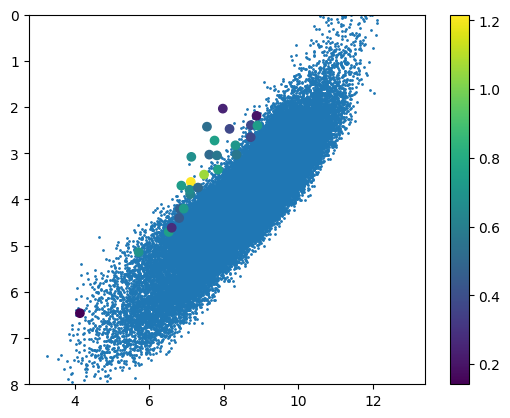

In [38]:
plt.scatter(samples[:,0],samples[:,1],s=1)
plt.scatter(hmc.data[valid,0],hmc.data[valid,1],c=np.sqrt(np.array(exts)[valid]))
plt.colorbar()
plt.ylim(8,0)


In [39]:
hmc.b

array([22.27463737, 22.36830267, 22.22606735, 22.25757912, 22.2100799 ,
       22.24039421, 22.26215686, 22.19138701, 22.15977482, 22.19265298,
       22.224503  , 22.21121294, 22.2978708 , 22.29369465, 22.28107655,
       22.32537375, 22.36669784, 22.31302715, 22.27764568, 22.33188601,
       22.35982733, 22.3806427 , 22.37738727, 22.33241706, 22.37387402,
       22.38603762, 22.25481307, 22.21406028, 22.2363717 , 22.27716477,
       22.2960434 , 22.42437759, 22.42740767, 22.45335365, 22.41842457,
       22.43586704, 22.43209726, 22.39051428])

(array([ 182580.,  145756.,   33605.,   78874.,       0.,       0.,
         160966., 3480600., 2931570.,  544483.]),
 array([-8.99358395e+01, -7.19424369e+01, -5.39490342e+01, -3.59556316e+01,
        -1.79622290e+01,  3.11735942e-02,  1.80245762e+01,  3.60179788e+01,
         5.40113814e+01,  7.20047840e+01,  8.99981867e+01]),
 <BarContainer object of 10 artists>)

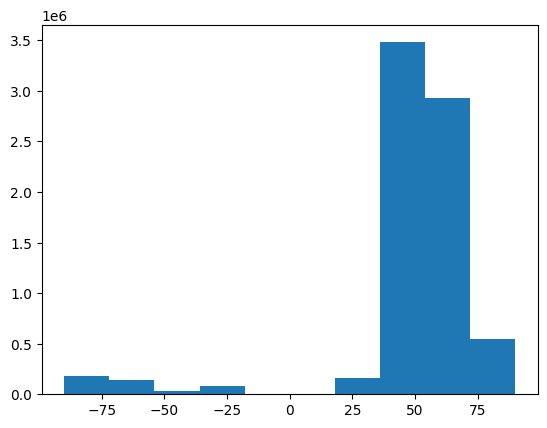

In [40]:
plt.hist(nf.b)

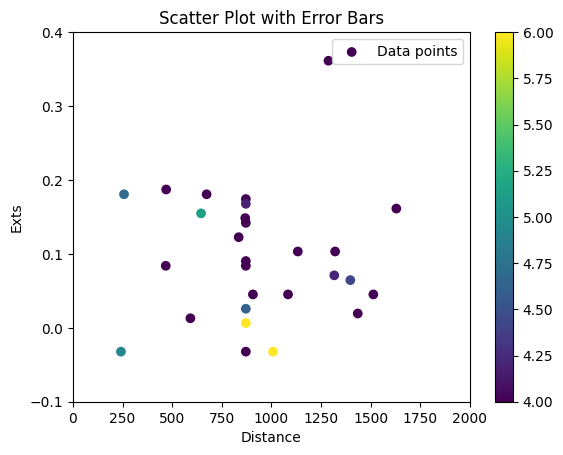

In [41]:
dist=nf.distance[valid]
plt.scatter(dist[valid], np.array(exts)[valid]/3.1,c=hmc.data[valid,1],vmin=4,vmax=6, label='Data points')
plt.colorbar()
# Add error bars

# Set x-axis limit
plt.xlim(0, 2000)
plt.ylim(-0.1,0.4)
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Exts')
plt.title('Scatter Plot with Error Bars')

# Optionally, add a legend
plt.legend()

# Show plot
plt.show()

(8.0, 0.0)

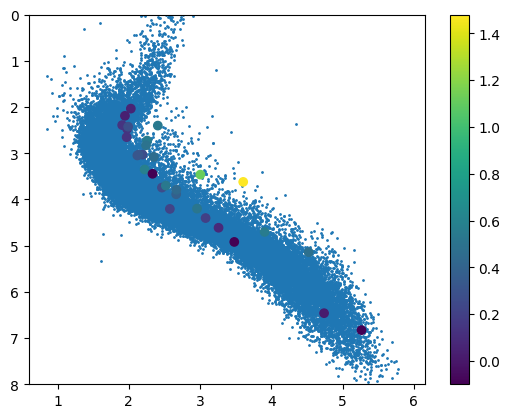

In [42]:
plt.scatter(samples[:,3],samples[:,1],s=1)
plt.scatter(hmc.data[valid,3],hmc.data[valid,1],c=np.array(exts)[valid])
plt.colorbar()
plt.ylim(8,0)


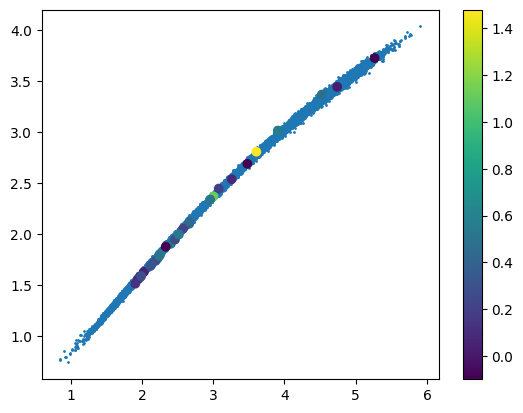

In [43]:
plt.scatter(samples[:,3],samples[:,2],s=1)
plt.scatter(hmc.data[valid,3],hmc.data[valid,2],c=np.array(exts)[valid])
plt.colorbar()


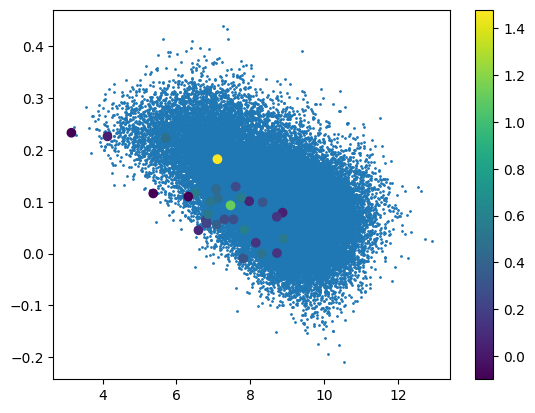

In [44]:
plt.scatter(samples[:,0],samples[:,6],s=1)
plt.scatter(hmc.data[valid,0],hmc.data[valid,6],c=np.array(exts)[valid])
plt.colorbar()
#plt.ylim(8,0)
